In [1]:
get_ipython().magic('matplotlib inline')

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import cross_validation, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
import pylab as pl
import xgboost as xgb

from functools import reduce

In [3]:
def itercols(dataframe):
    for col in dataframe.columns:
        yield (col, dataframe[col])

In [4]:
from pandas import read_csv, DataFrame, Series
data = read_csv('~/kaggle/santander/train.csv')

In [5]:
cdata = data.drop(['ID', 'TARGET'], axis=1)
cdata[[kv[0] for kv in filter(lambda kv: kv[1], cdata.mean().isnull().items())]].count()

Series([], dtype: int64)

In [6]:
#log scaling features with higher than criterion_to_log difference between min and max
criterion_to_log = 1e4
cols_to_log = [kv[0] for kv in filter(lambda nc: np.abs(nc[1].min() - nc[1].max()) > criterion_to_log, itercols(cdata))]
offsets = {}
for col in cols_to_log:
    offset = np.abs(cdata[col]).max() + 1
    offsets[col] = offset
    cdata[col] = np.log(cdata[col] + offset) - np.log(offset)

In [ ]:
#feature scaling
from sklearn import preprocessing

for col in cdata.columns:
    cdata[col] = preprocessing.StandardScaler().fit_transform(np.array(cdata[col]).astype(np.float64).reshape(-1,1))

In [ ]:
anyNaN = reduce(lambda x,y: x and y, [reduce(lambda x,y: x or y, cdata[col].isnull()) for col in cdata.columns])

In [ ]:
anyInf = reduce(lambda x,y: x and y, [reduce(lambda x,y: x or y, map(lambda z: z in [np.inf, -np.inf], cdata[col])) for col in cdata.columns])

In [ ]:
anyLarge = reduce(lambda x,y: x and y, [reduce(lambda x,y: x or y, map(lambda z: z >= np.finfo(np.float32).max, cdata[col])) for col in cdata.columns])

In [ ]:
print(anyNaN, anyInf, anyLarge)

In [ ]:
#throw away columns, where >= 80% of values is median
#cdata = data
#for col in cdata.columns[1:-1]:
#    ser = cdata[col]
#    cnt = ser.value_counts()
#    med = ser.median()
#    if cnt[med]/len(ser) >= 0.80:
#        cdata = cdata.drop([col], axis=1)

In [7]:
Y = data['TARGET']
X = cdata
kcv = 5
cvd = {}

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [9]:
model_rfc = RandomForestClassifier(n_estimators = 200, n_jobs=-1)
model_xgb = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

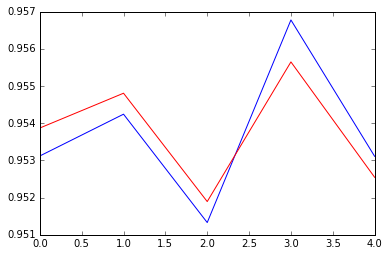

In [10]:
scores = cross_validation.cross_val_score(model_rfc, X_train, y_train, cv = kcv)
cvd['RandomForestClassifier'] = scores

scores = cross_validation.cross_val_score(model_rfc, X_train, y_train, cv = kcv)
cvd['XGBClassifier'] = scores

plt.plot(range(len(scores)), cvd['RandomForestClassifier'], 'b', range(len(scores)), cvd['XGBClassifier'], 'r')

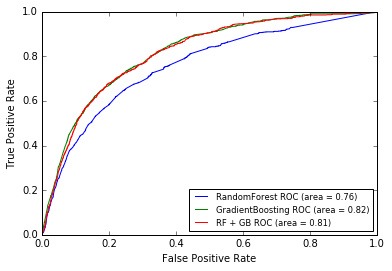

In [11]:
pl.clf()

rf_probas = model_rfc.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, rf_probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForest',roc_auc))

gb_probas = model_xgb.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, gb_probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('GradientBoosting',roc_auc))

rf_gb_probas = (rf_probas + gb_probas) / 2
fpr, tpr, thresholds = roc_curve(y_test, rf_gb_probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RF + GB',roc_auc))

pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

In [12]:
testdata = read_csv('~/kaggle/santander/test.csv')
ctestdata = testdata
for col in testdata.columns:
    if col not in cdata.columns:
        ctestdata = ctestdata.drop([col], axis=1)
#ctestdata = ctestdata.drop(['ID'], axis=1)

#log scaling test samle
for col in cols_to_log:
    offset = offsets[col]
    ctestdata[col] = np.log(cdata[col] + offset) - np.log(offset)

In [21]:
result = DataFrame(testdata['ID'])
result.insert(1,'TARGET', model_xgb.fit(X, Y).predict(ctestdata))
result.to_csv('~/ml/kaggle_santander_happy_customers/res_xgb.csv', index=False)

result = DataFrame(testdata['ID'])
result.insert(1,'TARGET', model_rfc.fit(X, Y).predict(ctestdata))
result.to_csv('~/ml/kaggle_santander_happy_customers/res_rf.csv', index=False)

result = DataFrame(testdata['ID'])
result.insert(1,'TARGET', np.ceil((model_rfc.fit(X, Y).predict(ctestdata) + model_xgb.fit(X, Y).predict(ctestdata)) / 2).astype(np.int32))
result.to_csv('~/ml/kaggle_santander_happy_customers/res_xgb_rf.csv', index=False)